In [1]:
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

import support_victor_machine as supp

In [2]:
data = pd.read_csv('../data/transactions_cleaned.csv')

data.dtypes

Unnamed: 0            int64
t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [3]:
data['Date'] = pd.to_datetime(data['t_dat'])

In [4]:
data.tail()

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id,Date
31651673,31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2,2020-09-22
31651674,31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2,2020-09-22
31651675,31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1,2020-09-22
31651676,31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1,2020-09-22
31651677,31788323,2020-09-22,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,898573003,0.033881,2,2020-09-22


In [5]:
# look at the the very last month's worth of transactions
most_recent = data[ data['Date'] > '2020-08-21' ]

most_recent

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id,Date
30464625,30597413,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,913688003,0.033881,2,2020-08-22
30464626,30597414,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,913688003,0.033881,2,2020-08-22
30464627,30597415,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,923460001,0.042356,2,2020-08-22
30464628,30597416,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,934380001,0.050831,2,2020-08-22
30464629,30597417,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,913688001,0.033881,2,2020-08-22
...,...,...,...,...,...,...,...
31651673,31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2,2020-09-22
31651674,31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2,2020-09-22
31651675,31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1,2020-09-22
31651676,31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1,2020-09-22


In [6]:
most_recent.nunique()

Unnamed: 0          1187053
t_dat                    32
customer_id          256244
article_id            29507
price                  4667
sales_channel_id          2
Date                     32
dtype: int64

In [7]:
most_recent_sales = most_recent.value_counts('article_id')

most_recent_sales

article_id
751471001    3080
915529003    2582
915526001    2573
918292001    2565
706016001    2565
             ... 
852448004       1
703672011       1
852513002       1
852521004       1
854724002       1
Length: 29507, dtype: int64

In [8]:
# look at the the very last month's worth of transactions
aug_2020 = data[ (data['Date'] > '2020-07-21') & (data['Date'] < '2020-08-21') ]

aug_2020

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id,Date
29187027,29314980,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,778064038,0.008458,2,2020-07-22
29187028,29314981,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,817166007,0.006763,2,2020-07-22
29187029,29314982,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,840360002,0.008458,2,2020-07-22
29187030,29314983,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,817166003,0.008458,2,2020-07-22
29187031,29314984,2020-07-22,00061a04f030bdf3665b09829192ca8c13c4de6dd9ae9d...,624486001,0.012729,2,2020-07-22
...,...,...,...,...,...,...,...
30430794,30563495,2020-08-20,fffcd4487ba8b7344dcd258c43cc6625397ca9e7aee005...,833499005,0.025407,2,2020-08-20
30430795,30563496,2020-08-20,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d...,896169002,0.042695,2,2020-08-20
30430796,30563497,2020-08-20,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d...,896152003,0.028458,2,2020-08-20
30430797,30563498,2020-08-20,ffff61677073258d461e043cc9ed4ed97be5617a920640...,810746001,0.018627,1,2020-08-20


In [9]:
aug2020_sales = aug_2020.value_counts(subset='article_id')

In [10]:
aug2020_sales

article_id
464297007    1703
759871002    1664
706016001    1627
372860002    1617
706016003    1581
             ... 
777467001       1
777441001       1
707307001       1
707349001       1
108775015       1
Length: 29955, dtype: int64

We can set a baseline by using the July to August sales as an estimate for the next month's sales figures.

In [11]:
baseline = pd.DataFrame({'aug':aug2020_sales, 'recent':most_recent_sales})

baseline

,aug,recent
article_id,,
108775015,1.0,NaN
108775044,24.0,19.0
110065001,1.0,NaN
110065002,3.0,NaN
110065011,NaN,2.0
...,...,...
952267001,NaN,41.0
952938001,NaN,9.0
953450001,NaN,17.0


We see a lot of ```NaN``` values in the resulting dataframe because of items which did not sell any units in the given months. We thus should impute these with a value of 0

In [12]:
baseline.fillna(0, inplace=True)

baseline.isnull().sum()

aug       0
recent    0
dtype: int64

Now let's use our "model" to make a prediction. For any given item, our model will use the August sales figures as the prediction for the next month's sales figures.

In [13]:
y_preds = baseline['aug']
y_test = baseline['recent']

print("RMSE", mean_squared_error(y_test, y_preds, squared = False))
print(" ")
print("MAE: ", mean_absolute_error(y_test, y_preds))
print(" ")

RMSE 104.82911767508848
 
MAE:  35.50593997780965
 


So the RMSE comes out to be +/- 105 units and MAE +/- 35.5 units. It's not clear whether these numbers are large or small, so let's take a look at some descriptive statistics for the sales figures.

In [14]:
y_test.describe()

count    36953.000000
mean        32.123319
std        107.497997
min          0.000000
25%          1.000000
50%          4.000000
75%         18.000000
max       3080.000000
Name: recent, dtype: float64

<AxesSubplot:>

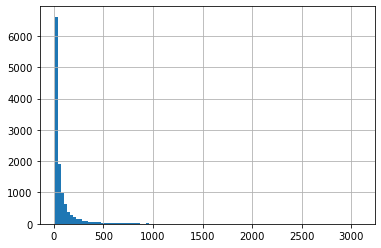

In [15]:
y_test[y_test > 10].hist(bins=100)

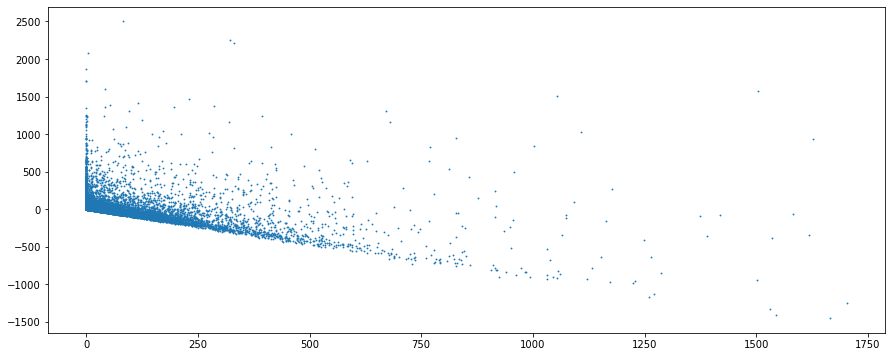

In [16]:
residuals = y_test - y_preds

plt.figure(figsize=(15,6))
plt.scatter(x=y_preds, y=residuals, s=0.7);

The residual plot has a rather interesting shape. It's quite clear that we have an underfitting issue, which is no surprise at all considering how simplistic our model is.

We can also attempt to use the sales figures in August to create a popularity based recommender system. In this case, we'll take the top 20 best selling items in August and recommend these items to all users. This approach is analogous to a Netflix Top 10 Most Popular list.

In [17]:
aug2020_sales[0:20]

article_id
464297007    1703
759871002    1664
706016001    1627
372860002    1617
706016003    1581
559616013    1543
827968001    1535
806225002    1530
751471001    1504
717490064    1502
866731001    1418
760084003    1389
730683050    1373
759871025    1286
351484039    1270
717490008    1265
816423004    1260
841383002    1249
599580038    1229
866383006    1223
dtype: int64

In [18]:
aug2020_top20 = [supp.get_image(idx) for idx in aug2020_sales[0:20].index]

In [19]:
aug2020_top20[0].shape

torch.Size([3, 128, 96])

For example, a prototype dashboard/landing page for site-users might look something like this:

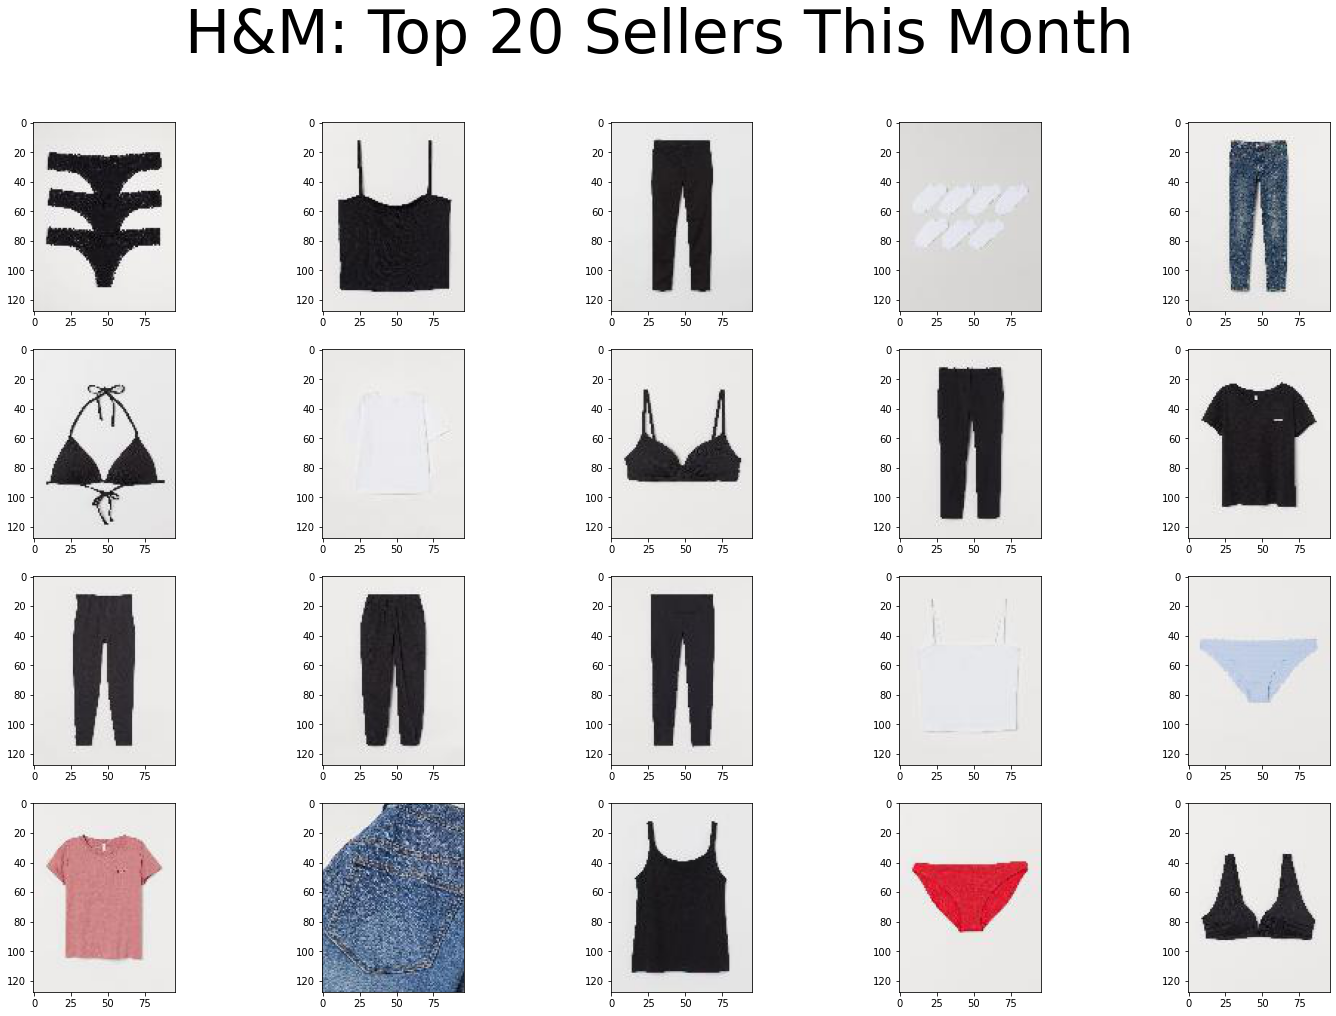

In [20]:
fig = plt.figure(figsize=(25, 16))

rows=4
columns=5

for i in range(20):
    fig.add_subplot(rows, columns, i+1)
    img = aug2020_top20[i]
    imgplot = plt.imshow(img.permute(1,2,0))
    
plt.suptitle("H&M: Top 20 Sellers This Month", fontsize=60);

<br>

---

<br>

---

# An Image Based Model

In [24]:
aug2020_sales_df.to_csv('../data/aug2020sales.csv')

In [25]:
# create a torch Dataset object for inputting into our neuarl network
class Aug2020DataSet(Dataset):
    
    def __init__(self):
        self.img_labels = aug2020_sales_df['sales']
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = torch.div(supp.get_image(aug2020_sales_df.loc[idx, 'article_id']),255)
        label = self.img_labels[idx]
        
        return image, label
    
    
train_data = Aug2020DataSet()

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


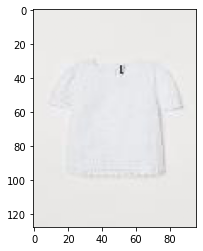

In [26]:
train_features, train_labels = next(iter(train_loader))
img = train_features[0].squeeze()
plt.imshow(img.permute(1,2,0))
plt.show()

In [31]:
# build the model
class FashionNet(nn.Module):
    
    def __init__(self):
        super(FashionNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, device='cuda')
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=5, device='cuda')
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=5, device='cuda')
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=5, device='cuda')
        self.hidden1 = nn.Linear(59904, 400, device='cuda')
        self.hidden2 = nn.Linear(400, 100, device='cuda')
        self.output = nn.Linear(100, 1, device='cuda')
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x,1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        output = F.relu(self.output(x))
        
        return output


In [32]:
# define training loop
def train_network(model, loader, criterion, optimizer, epochs=1, cuda=False, report=None):
    if cuda==True:
        model.to('cuda')
        
    num_batches = len(loader)
    for epoch in range(epochs):
        for batch, (examples, labels) in enumerate(loader):
            if cuda == True:
                examples = examples.to('cuda').type(torch.float32)
                labels = labels.to('cuda').type(torch.float32).view(labels.shape[0],1)
            # forward pass
            output = model(examples)
            # compute loss
            loss = criterion(output, labels)
            # reset gradient
            optimizer.zero_grad()
            # backpropagation via autograd
            loss.backward()
            # descend
            optimizer.step()
            
            # print progress report; controlled by verbose parameter
            if report!= None:
                if (batch+1)%report == 0:
                    print(f'Epoch {epoch+1} / {epochs}, batch {batch+1}/{num_batches}, loss = {loss.item():.5f}')



In [33]:
aug_model = FashionNet()

learning_rate = 0.0001
reg_strength = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr = learning_rate, weight_decay = reg_strength)

In [34]:
train_network(aug_model, train_loader, criterion, optimizer, epochs=5, cuda=True, report = 100)

Epoch 1 / 5, batch 100/469, loss = 8372.07812
Epoch 1 / 5, batch 200/469, loss = 2735.57812
Epoch 1 / 5, batch 300/469, loss = 11295.03125
Epoch 1 / 5, batch 400/469, loss = 26421.45312
Epoch 2 / 5, batch 100/469, loss = 15794.84375
Epoch 2 / 5, batch 200/469, loss = 3402.28125
Epoch 2 / 5, batch 300/469, loss = 18134.50000
Epoch 2 / 5, batch 400/469, loss = 49135.59375
Epoch 3 / 5, batch 100/469, loss = 3693.51562
Epoch 3 / 5, batch 200/469, loss = 5932.87109
Epoch 3 / 5, batch 300/469, loss = 6797.42725
Epoch 3 / 5, batch 400/469, loss = 4606.53516
Epoch 4 / 5, batch 100/469, loss = 2608.32153
Epoch 4 / 5, batch 200/469, loss = 1972.87476
Epoch 4 / 5, batch 300/469, loss = 22619.64062
Epoch 4 / 5, batch 400/469, loss = 19036.37500
Epoch 5 / 5, batch 100/469, loss = 4255.23584
Epoch 5 / 5, batch 200/469, loss = 6815.33447
Epoch 5 / 5, batch 300/469, loss = 8399.78027
Epoch 5 / 5, batch 400/469, loss = 6156.47852


In [35]:
most_recent_df = most_recent.value_counts('article_id').reset_index().rename(columns={0:'sales'})

most_recent_df

,article_id,sales
0,751471001,3080
1,915529003,2582
2,915526001,2573
3,918292001,2565
4,706016001,2565
...,...,...
29502,852448004,1
29503,703672011,1
29504,852513002,1
29505,852521004,1


In [36]:
test_df = most_recent_df[ ~most_recent_df['article_id'].isin(aug2020_sales.index) ].reset_index(drop=True)

test_df

,article_id,sales
0,909370001,1868
1,924243001,1705
2,918522001,1702
3,865799006,1343
4,762846027,1260
...,...,...
6993,702932017,1
6994,703805001,1
6995,703806003,1
6996,852389001,1


In [37]:
# create a torch Dataset object for inputting into our neuarl network
class TestDataSet(Dataset):
    
    def __init__(self):
        self.img_labels = test_df['sales']
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = supp.get_image(test_df.loc[idx, 'article_id'])
        label = self.img_labels[idx]
        
        return image, label
    
    
test_data = TestDataSet()

test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [38]:
running_loss = 0
with torch.no_grad():
    for i, (img, label) in enumerate(test_loader):
        img = torch.div(img.to('cuda').type(torch.float32),255)
        label = label.to('cuda').type(torch.float32).view(label.shape[0],1)
        output = aug_model(img)
        loss = criterion(output, label)
        running_loss+=loss.item()
        
test_mse = running_loss/len(test_loader)

In [39]:
np.math.sqrt(test_mse)

108.08777806463598

In [40]:
# create a torch Dataset object for inputting into our neuarl network
class MostRecentDataSet(Dataset):
    
    def __init__(self):
        self.img_labels = most_recent_df['sales']
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = supp.get_image(most_recent_df.loc[idx, 'article_id'])
        label = self.img_labels[idx]
        
        return image, label
    
    
recent_data = MostRecentDataSet()

recent_loader = DataLoader(recent_data, batch_size=1, shuffle=False)


In [41]:
running_loss = 0
with torch.no_grad():
    for i, (img, label) in enumerate(recent_loader):
        img = torch.div(img.to('cuda').type(torch.float32),255)
        label = label.to('cuda').type(torch.float32).view(label.shape[0],1)
        output = aug_model(img)
        loss = criterion(output, label)
        running_loss+=loss.item()
        
recent_mse = running_loss/len(recent_loader)

In [42]:
np.math.sqrt(recent_mse)

119.36810030935328

In [43]:
torch.save(aug_model.state_dict(), '../models/aug_model2.pth')

In [44]:
aug_model_load = FashionNet()
aug_model_load.load_state_dict(torch.load('../models/aug_model2.pth'))

<All keys matched successfully>